In [22]:
"""Возьмите датасет «Финансовая отчётность российских компаний» и
проанализируйте его с помощью Pandas или Polars.
ВАЖНО: Перед началом анализа сократите количество колонок до 20 и
количество строк до 1000. Также, можете использовать streaming, чтобы
не скачивать сразу весь датасет."""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from itertools import islice  # Для ограничения строк

In [33]:
# Загружаем датасет с streaming
# Шаг 1: Загрузка датасета с streaming и ограничение до 1000 строк
print("Загрузка датасета...")
dataset = load_dataset("irlspbru/RFSD", split="train", streaming=True)
df = pd.DataFrame(list(dataset.take(1000)))  # Берем первые 1000 строк
print(f"Загружено {len(df)} строк.")

# Шаг 2: Переименование столбцов с помощью справочника
print("Переименование столбцов...")
renaming_df_url = 'https://raw.githubusercontent.com/irlcode/RFSD/main/aux/descriptive_names_dict.csv'
renaming_df = pd.read_csv(renaming_df_url)
renaming_dict = {orig: new for orig, new in zip(renaming_df['original'], renaming_df['descriptive']) if orig in df.columns}
df.rename(columns=renaming_dict, inplace=True)
#print("Переименованные столбцы:", list(renaming_dict.values()))

# Шаг 3: Выбор 17 значимых колонок из списка (адаптируйте, если названий нет)
significant_columns = ['year','ogrn','region','age','B_fixed_assets','B_current_assets','B_accounts_receivable','B_inventories','B_total_equity',
                       'B_charter_capital','B_reserve_capital',
'B_assets','PL_revenue','PL_gross_profit','PL_income_tax','PL_tax_liab','PL_net_profit','PL_reval','CFi_loans','PU_income_activities'] 
# Ограничено до 17; если названий нет, замените на реальные из df.columns
df = df[[col for col in significant_columns if col in df.columns]]
print(f"Выбрано {len(df.columns)} колонок из 17.")

# Шаг 4: Добавление новых колонок
print("Добавление новых колонок...")
# ROA: net_profit / assets
df['ROA'] = df['PL_net_profit'] / df['B_assets']
df['ROE'] = df['PL_net_profit'] / df['B_total_equity']

print(df.info())

Загрузка датасета...
Загружено 1000 строк.
Переименование столбцов...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 213 entries, inn to PU_remaining
dtypes: float64(61), object(152)
memory usage: 1.6+ MB
None
Выбрано 19 колонок из 17.
Добавление новых колонок...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ogrn                   1000 non-null   object 
 1   region                 1000 non-null   object 
 2   age                    1000 non-null   float64
 3   B_fixed_assets         234 non-null    float64
 4   B_current_assets       331 non-null    float64
 5   B_accounts_receivable  217 non-null    float64
 6   B_inventories          269 non-null    float64
 7   B_total_equity         328 non-null    float64
 8   B_charter_capital      49 non-null     float64
 9   B_reserve_capital 

In [34]:
# 1. Описательная статистика
print("Описательная статистика:")
print(df.describe())

Описательная статистика:
               age  B_fixed_assets  B_current_assets  B_accounts_receivable  \
count  1000.000000       234.00000      3.310000e+02           2.170000e+02   
mean      6.595000     13379.92735      1.756577e+04           1.314241e+04   
std       4.784545     43709.45330      1.016735e+05           8.346032e+04   
min       0.000000         2.00000      1.000000e+00           1.000000e+00   
25%       3.000000        19.00000      1.970000e+02           7.600000e+01   
50%       5.000000       247.00000      7.800000e+02           6.980000e+02   
75%      10.000000      4656.00000      4.414000e+03           3.422000e+03   
max      26.000000    521931.00000      1.650913e+06           1.177298e+06   

       B_inventories  B_total_equity  B_charter_capital  B_reserve_capital  \
count     269.000000      328.000000          49.000000          13.000000   
mean     9596.078067     7434.975610        7185.571429         169.538462   
std     34421.872980    26794

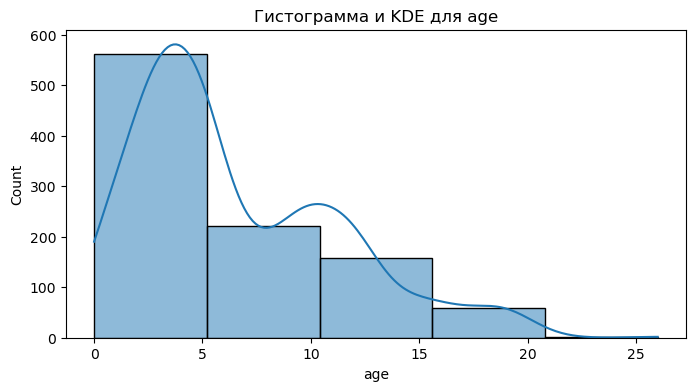

Колонка age: выбросов найдено 2 (0.20%)


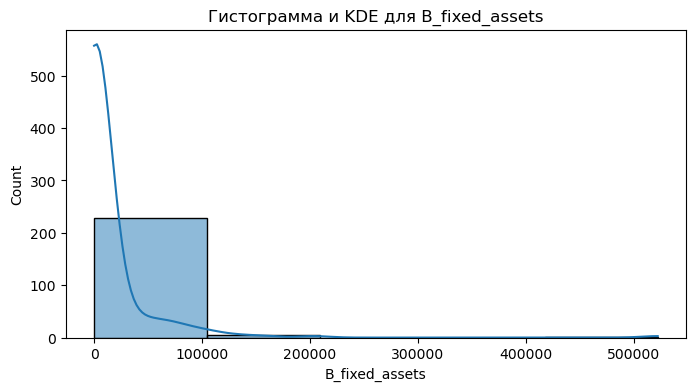

Колонка B_fixed_assets: выбросов найдено 41 (4.10%)


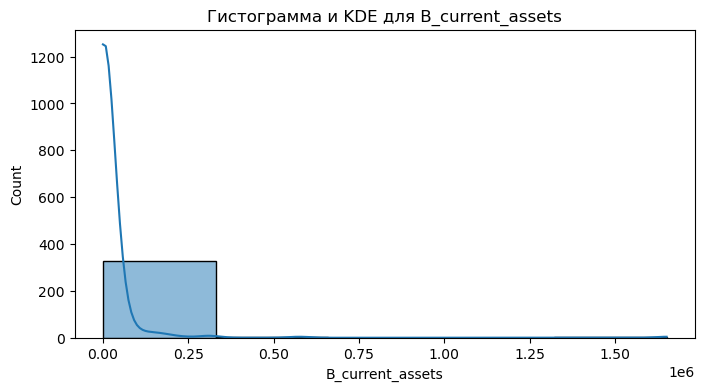

Колонка B_current_assets: выбросов найдено 51 (5.10%)


In [35]:
# 2. Построение гистограмм и анализ выбросов
# Для примера выберем первые 3 числовые колонки
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
hist_cols = numeric_cols[:3]

for col in hist_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), bins=5, kde=True)
    plt.title(f"Гистограмма и KDE для {col}")
    plt.show()

    # Анализ выбросов через межквартильный размах (IQR)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Колонка {col}: выбросов найдено {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

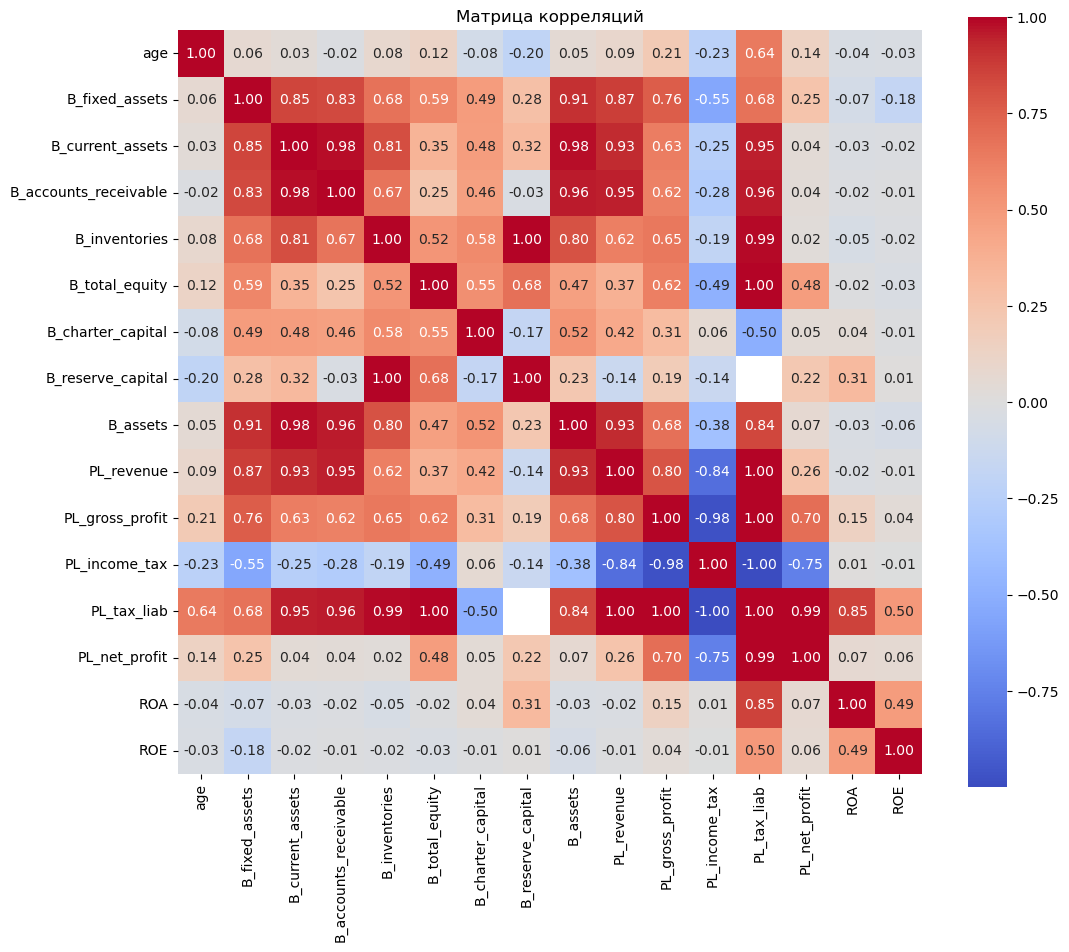

Пары колонок с высокой корреляцией (>0.7 по модулю):
B_fixed_assets и B_current_assets: r = 0.85
B_fixed_assets и B_accounts_receivable: r = 0.83
B_fixed_assets и B_assets: r = 0.91
B_fixed_assets и PL_revenue: r = 0.87
B_fixed_assets и PL_gross_profit: r = 0.76
B_current_assets и B_accounts_receivable: r = 0.98
B_current_assets и B_inventories: r = 0.81
B_current_assets и B_assets: r = 0.98
B_current_assets и PL_revenue: r = 0.93
B_current_assets и PL_tax_liab: r = 0.95
B_accounts_receivable и B_assets: r = 0.96
B_accounts_receivable и PL_revenue: r = 0.95
B_accounts_receivable и PL_tax_liab: r = 0.96
B_inventories и B_reserve_capital: r = 1.00
B_inventories и B_assets: r = 0.80
B_inventories и PL_tax_liab: r = 0.99
B_total_equity и PL_tax_liab: r = 1.00
B_assets и PL_revenue: r = 0.93
B_assets и PL_tax_liab: r = 0.84
PL_revenue и PL_gross_profit: r = 0.80
PL_revenue и PL_income_tax: r = -0.84
PL_revenue и PL_tax_liab: r = 1.00
PL_gross_profit и PL_income_tax: r = -0.98
PL_gross_profi

In [36]:
#3. Матрица корреляций и визуализация
plt.figure(figsize=(12,10))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Матрица корреляций")
plt.show()

# Найдем пары с высокой корреляцией (например, |r| > 0.7)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i,j]
        if abs(r) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], r))

print("Пары колонок с высокой корреляцией (>0.7 по модулю):")
for c1, c2, r in high_corr:
    print(f"{c1} и {c2}: r = {r:.2f}")

Text(0.5, 1.0, 'Scatter plot: B_fixed_assets vs B_current_assets (r=0.85)')


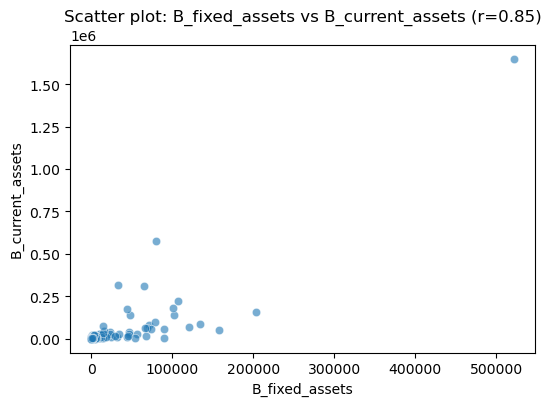

None
Text(0.5, 1.0, 'Scatter plot: B_fixed_assets vs B_accounts_receivable (r=0.83)')


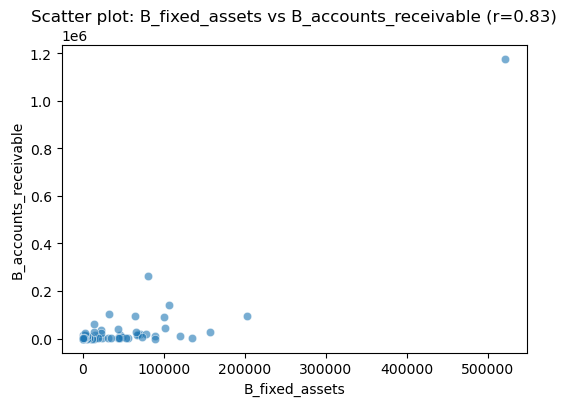

None
Text(0.5, 1.0, 'Scatter plot: B_fixed_assets vs B_assets (r=0.91)')


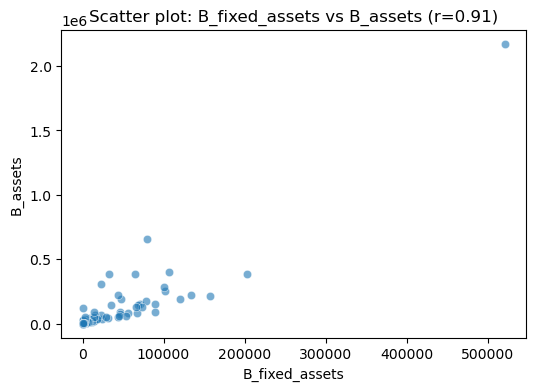

None
Text(0.5, 1.0, 'Scatter plot: B_fixed_assets vs PL_revenue (r=0.87)')


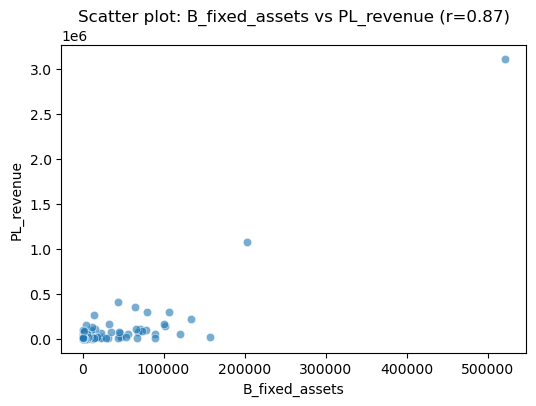

None
Text(0.5, 1.0, 'Scatter plot: B_fixed_assets vs PL_gross_profit (r=0.76)')


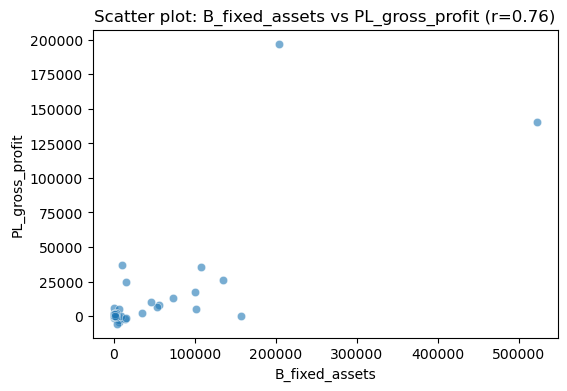

None
Text(0.5, 1.0, 'Scatter plot: B_current_assets vs B_accounts_receivable (r=0.98)')


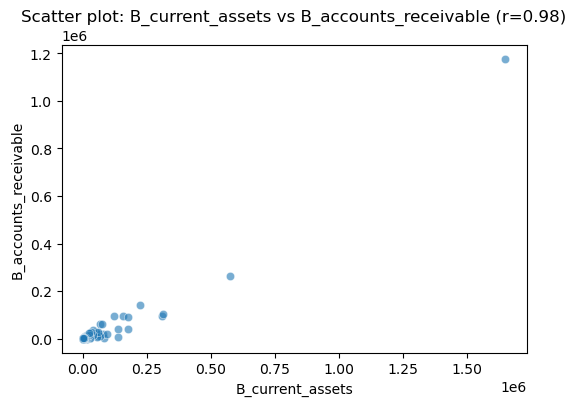

None
Text(0.5, 1.0, 'Scatter plot: B_current_assets vs B_inventories (r=0.81)')


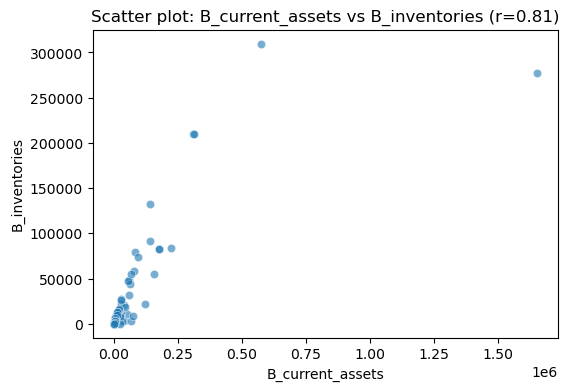

None
Text(0.5, 1.0, 'Scatter plot: B_current_assets vs B_assets (r=0.98)')


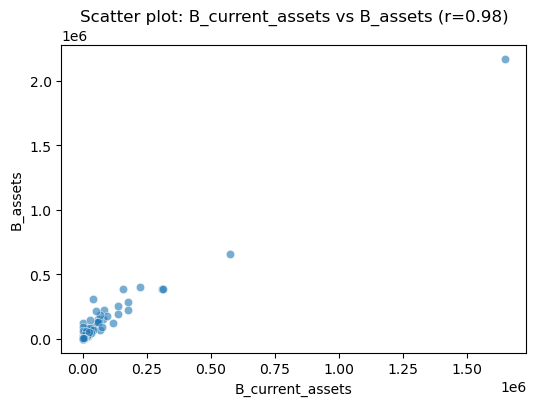

None
Text(0.5, 1.0, 'Scatter plot: B_current_assets vs PL_revenue (r=0.93)')


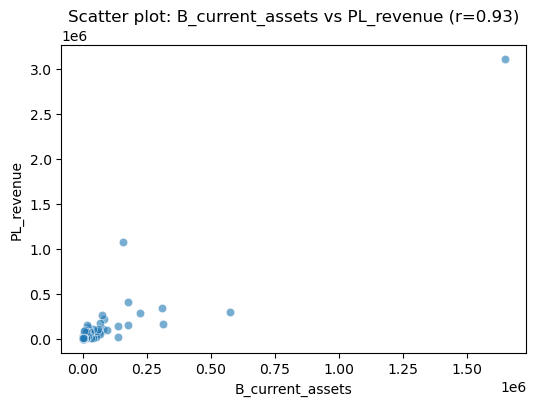

None
Text(0.5, 1.0, 'Scatter plot: B_current_assets vs PL_tax_liab (r=0.95)')


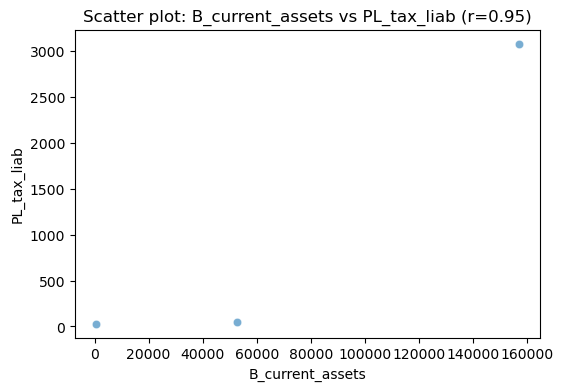

None
Text(0.5, 1.0, 'Scatter plot: B_accounts_receivable vs B_assets (r=0.96)')


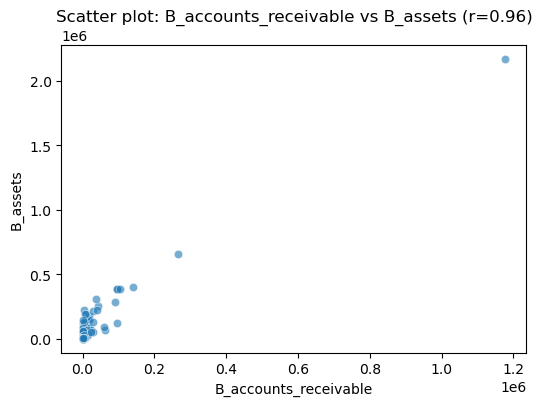

None
Text(0.5, 1.0, 'Scatter plot: B_accounts_receivable vs PL_revenue (r=0.95)')


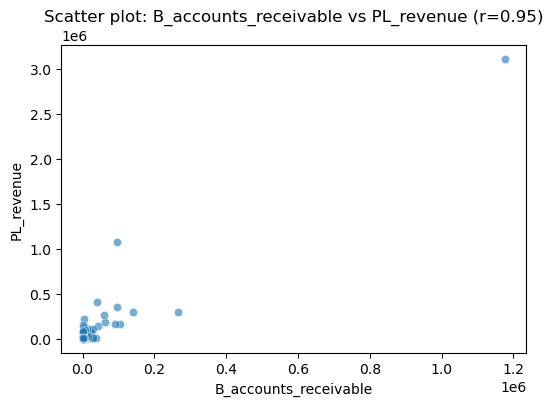

None
Text(0.5, 1.0, 'Scatter plot: B_accounts_receivable vs PL_tax_liab (r=0.96)')


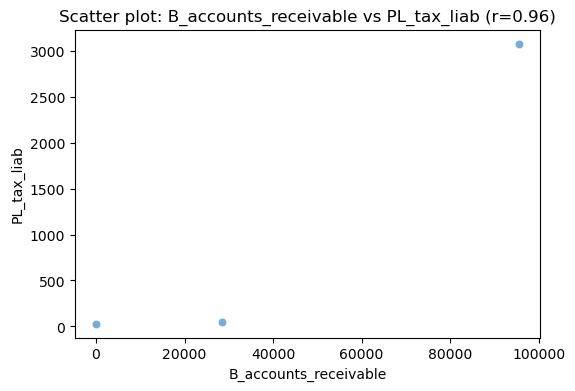

None
Text(0.5, 1.0, 'Scatter plot: B_inventories vs B_reserve_capital (r=1.00)')


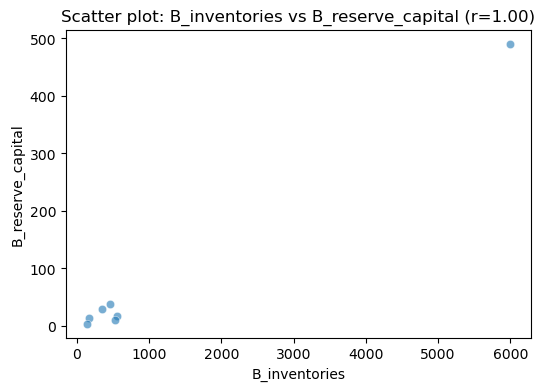

None
Text(0.5, 1.0, 'Scatter plot: B_inventories vs B_assets (r=0.80)')


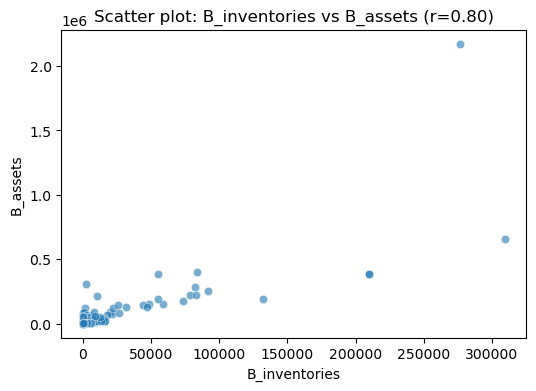

None
Text(0.5, 1.0, 'Scatter plot: B_inventories vs PL_tax_liab (r=0.99)')


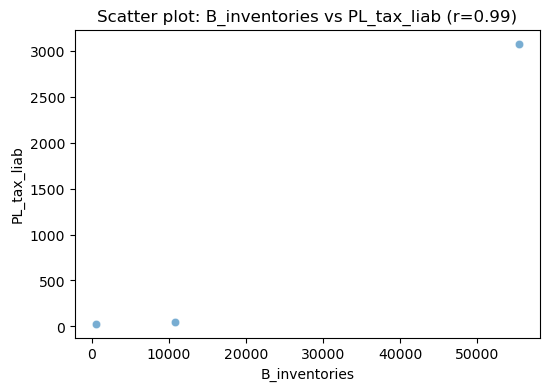

None
Text(0.5, 1.0, 'Scatter plot: B_total_equity vs PL_tax_liab (r=1.00)')


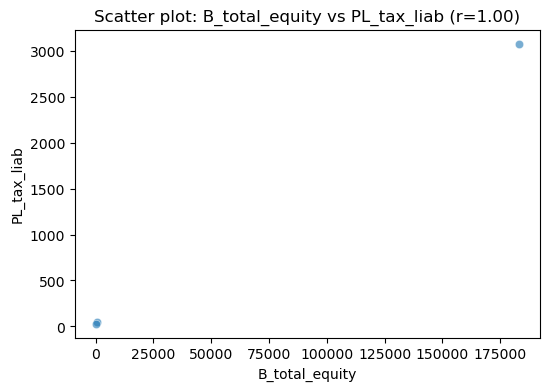

None
Text(0.5, 1.0, 'Scatter plot: B_assets vs PL_revenue (r=0.93)')


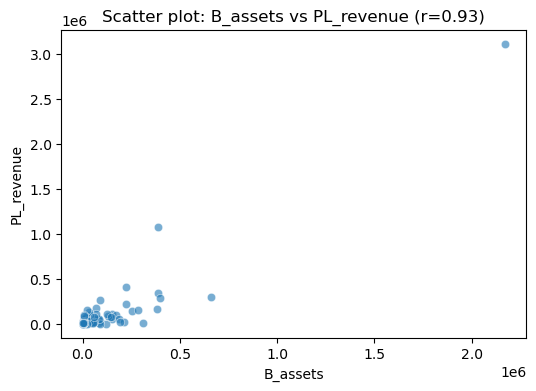

None
Text(0.5, 1.0, 'Scatter plot: B_assets vs PL_tax_liab (r=0.84)')


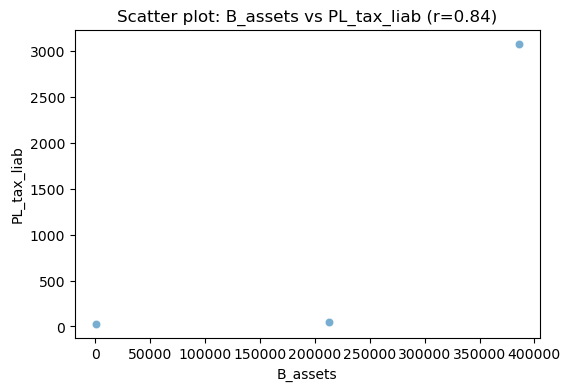

None
Text(0.5, 1.0, 'Scatter plot: PL_revenue vs PL_gross_profit (r=0.80)')


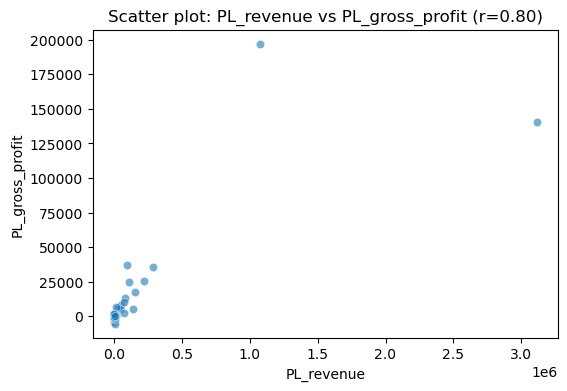

None
Text(0.5, 1.0, 'Scatter plot: PL_revenue vs PL_income_tax (r=-0.84)')


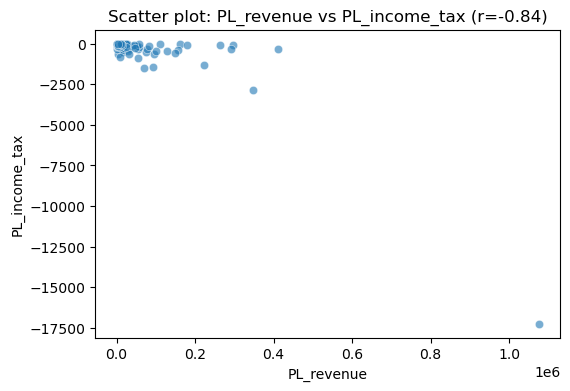

None
Text(0.5, 1.0, 'Scatter plot: PL_revenue vs PL_tax_liab (r=1.00)')


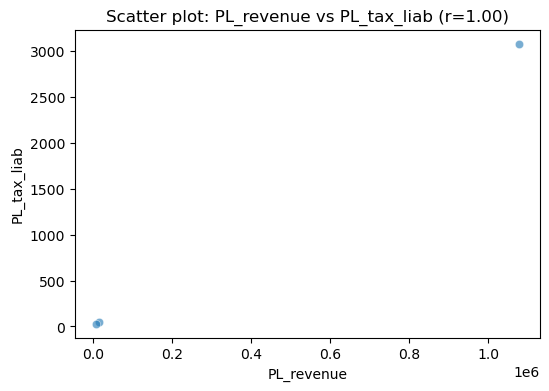

None
Text(0.5, 1.0, 'Scatter plot: PL_gross_profit vs PL_income_tax (r=-0.98)')


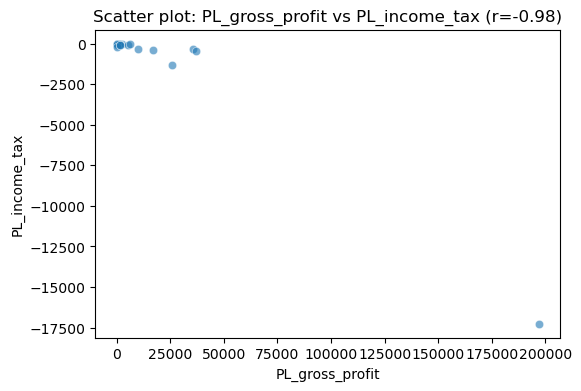

None
Text(0.5, 1.0, 'Scatter plot: PL_gross_profit vs PL_tax_liab (r=1.00)')


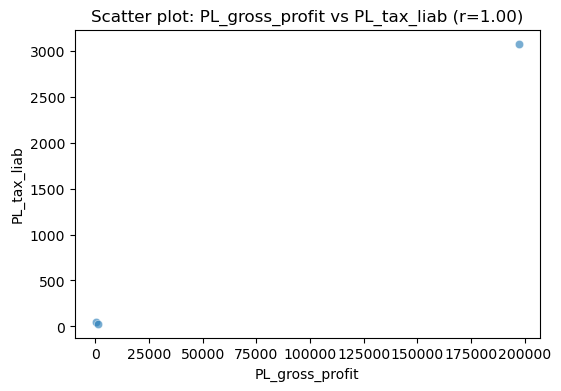

None
Text(0.5, 1.0, 'Scatter plot: PL_income_tax vs PL_tax_liab (r=-1.00)')


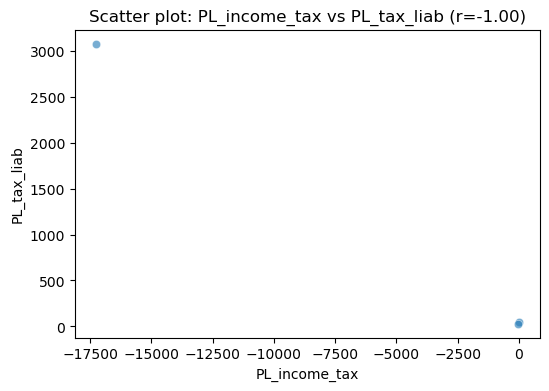

None
Text(0.5, 1.0, 'Scatter plot: PL_income_tax vs PL_net_profit (r=-0.75)')


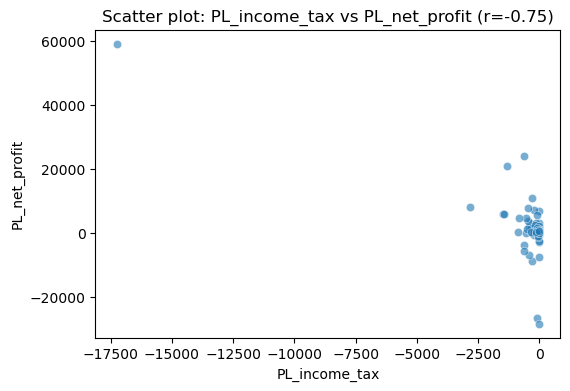

None
Text(0.5, 1.0, 'Scatter plot: PL_tax_liab vs PL_net_profit (r=0.99)')


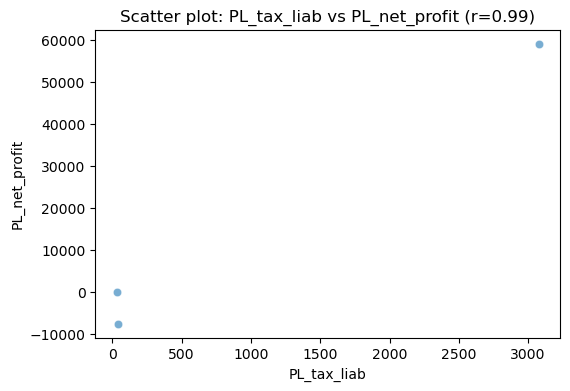

None
Text(0.5, 1.0, 'Scatter plot: PL_tax_liab vs ROA (r=0.85)')


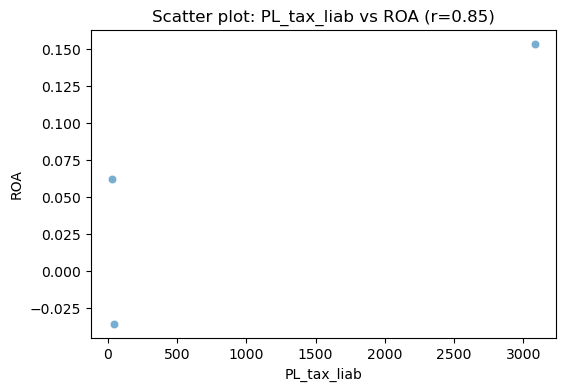

None


In [40]:
#4. Диаграммы рассеивания для коррелирующих колонок
for c1, c2, r in high_corr:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=c1, y=c2, alpha=0.6)
    print(plt.title(f"Scatter plot: {c1} vs {c2} (r={r:.2f})"))
    print(plt.show())
    

In [38]:
''' 5.Выводы по анализу:
1) Датасет содержит много пустых строк по разным столбцам, 
для машинного обучения необходимо будет или дополнять эти столбцы данными (усредненными или иначе). Есть дубли столбцов по смыслу
2) Из гистограммы возраста видно, то основная масса компаний возрастом 3-5 лет, чем больше возраст, тем число компаний падает
3) Из гистограммы основных средств видно, что у большей части компаний они не превышают 100 000
4) Из гистограммы оборотных активов видно, что их объем также коррелируется
5) Под тепловой картой выведены наиболее коррелируемые колонки.
6) На диаграммах рассеивания видны точечные выбросы в разрезе коррелируемых колонок
Аномалия - Выбросы в total_assets (например, компании с активами > 1e9 могут быть гигантами или ошибками в данных)
Закономерность - Высокая корреляция между revenue и net_profit (ожидаемо, так как прибыль зависит от доходов)
Неожиданная связь - Низкая корреляция между ROA и ROE может говорить о наличии заемных средств, но столбец с кредитами чаще содержит пустые значения'''

SyntaxError: incomplete input (993517374.py, line 1)